[*********************100%***********************]  1 of 1 completed


Dataset shape: (3522, 6)

Dataset Information:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3522 entries, 0 to 3521
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   (Date, )        3522 non-null   datetime64[ns]
 1   (Close, AAPL)   3522 non-null   float64       
 2   (High, AAPL)    3522 non-null   float64       
 3   (Low, AAPL)     3522 non-null   float64       
 4   (Open, AAPL)    3522 non-null   float64       
 5   (Volume, AAPL)  3522 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 165.2 KB
None

Statistical Summary:

Price                            Date        Close         High          Low  \
Ticker                                        AAPL         AAPL         AAPL   
count                            3522  3522.000000  3522.000000  3522.000000   
mean    2016-12-30 22:57:51.209540096    57.434097    58.012507    56.801269   
min        

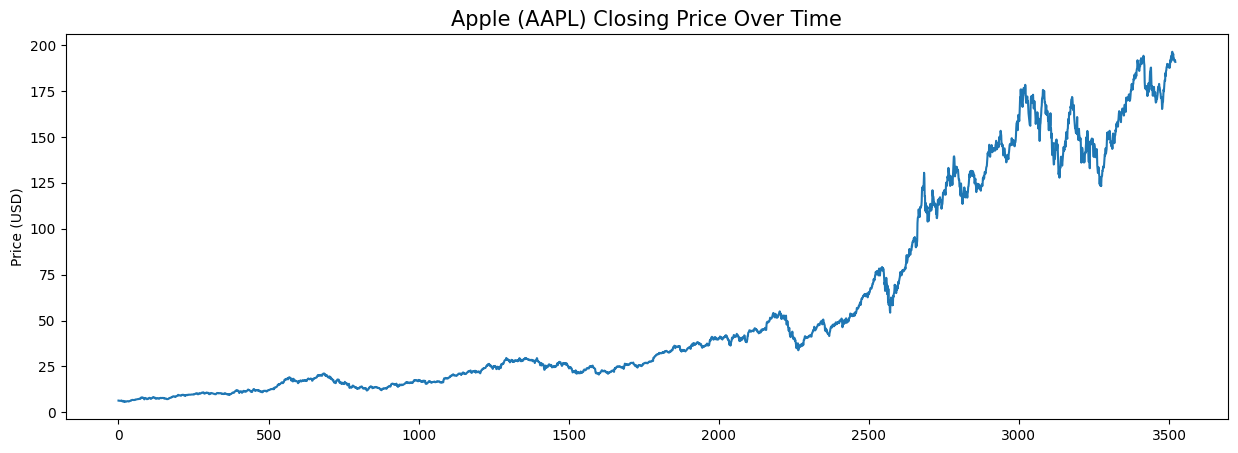


Checking for missing values:

Price   Ticker
Date              0
Close   AAPL      0
High    AAPL      0
Low     AAPL      0
Open    AAPL      0
Volume  AAPL      0
dtype: int64


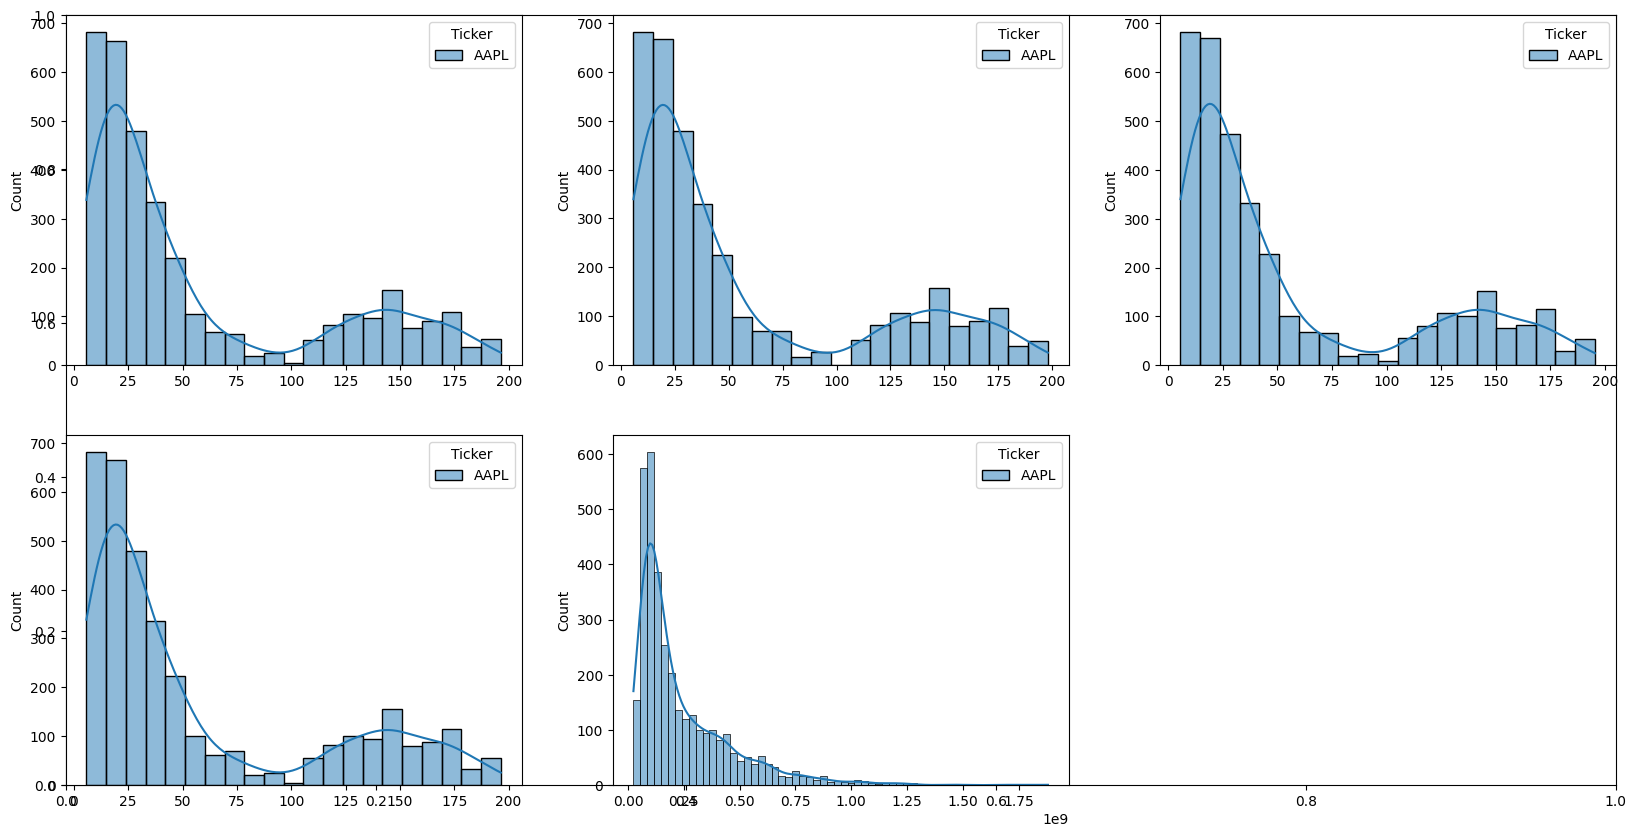

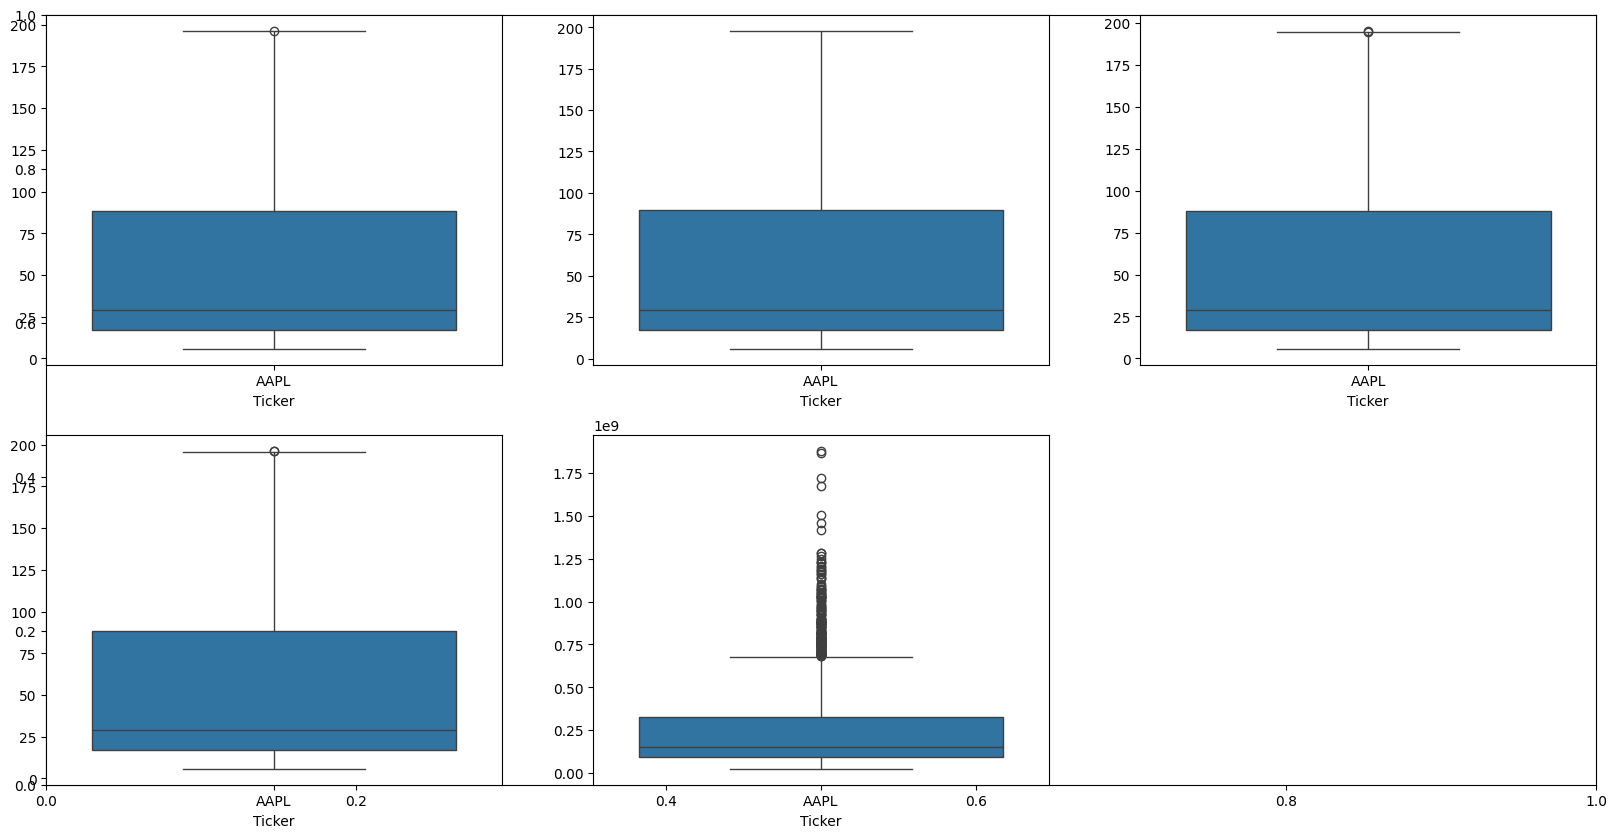


Target variable distribution:


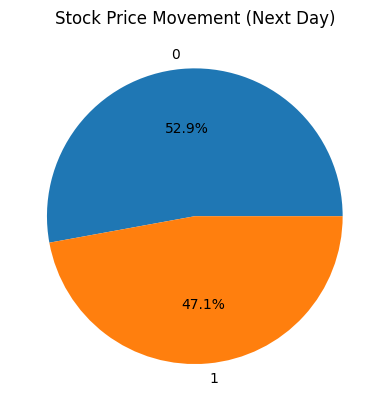

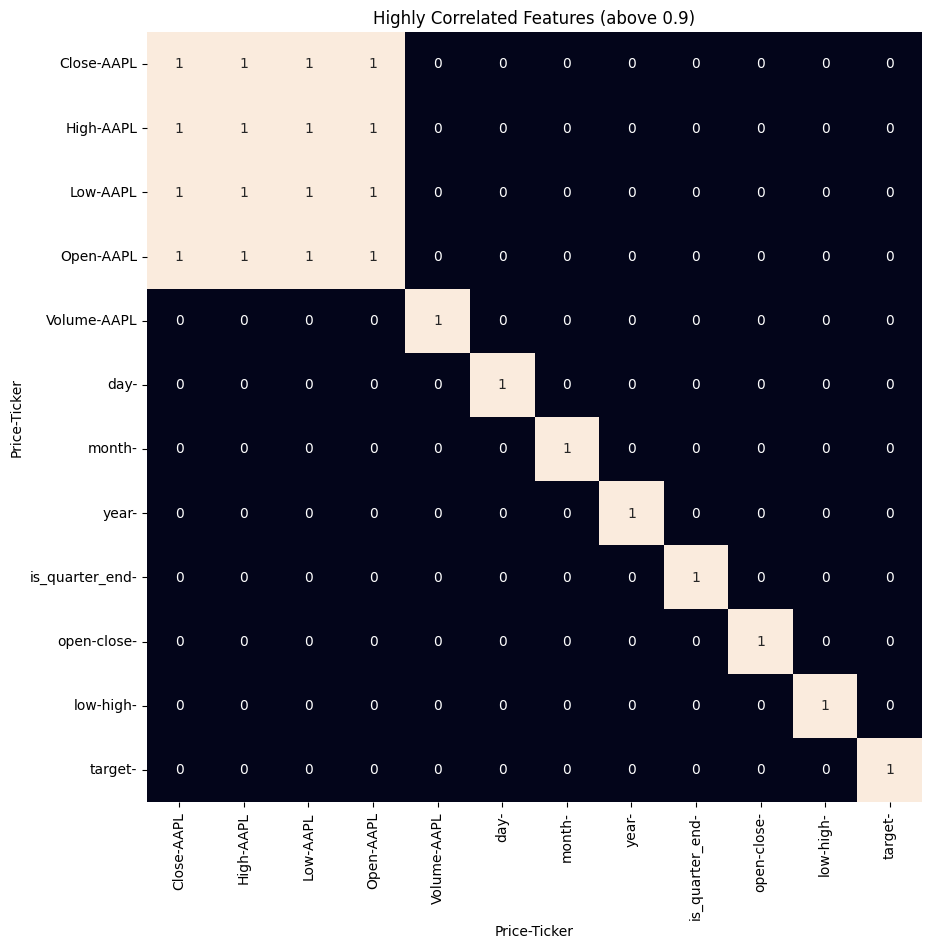

Training shape: (3169, 3)
Validation shape: (353, 3)

LogisticRegression() : 
Training ROC-AUC :  0.5122303336889593
Validation ROC-AUC :  0.5656028368794326

SVC(kernel='poly', probability=True) : 
Training ROC-AUC :  0.501881620535197
Validation ROC-AUC :  0.5622501611863314

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=Non

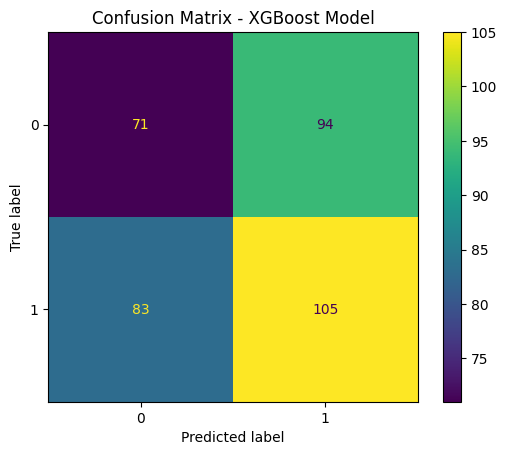

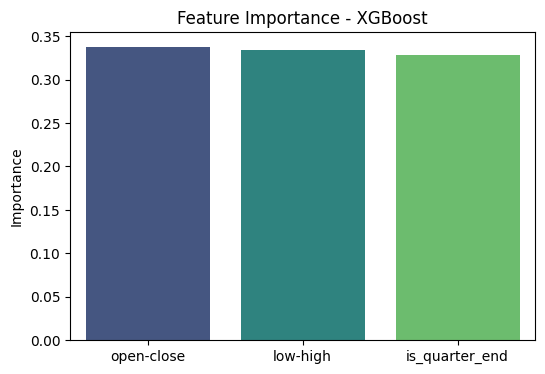

In [1]:


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')



df = yf.download('AAPL', start='2010-01-01', end='2023-12-31')
df.reset_index(inplace=True)

print("Dataset shape:", df.shape)
df.head()



print("\nDataset Information:\n")
print(df.info())
print("\nStatistical Summary:\n")
print(df.describe())

plt.figure(figsize=(15,5))
plt.plot(df['Close'])
plt.title('Apple (AAPL) Closing Price Over Time', fontsize=15)
plt.ylabel('Price (USD)')
plt.show()



# Drop unnecessary columns if any
df = df.dropna()

print("\nChecking for missing values:\n")
print(df.isnull().sum())



features = ['Open', 'High', 'Low', 'Close', 'Volume']

plt.subplots(figsize=(20,10))
for i, col in enumerate(features):
    plt.subplot(2,3,i+1)
    sb.histplot(df[col], kde=True)
plt.show()

plt.subplots(figsize=(20,10))
for i, col in enumerate(features):
    plt.subplot(2,3,i+1)
    sb.boxplot(df[col])
plt.show()



df['day'] = df['Date'].dt.day
df['month'] = df['Date'].dt.month
df['year'] = df['Date'].dt.year
df['is_quarter_end'] = np.where(df['month']%3==0,1,0)

df['open-close'] = df['Open'] - df['Close']
df['low-high'] = df['Low'] - df['High']


df['target'] = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)

print("\nTarget variable distribution:")
plt.pie(df['target'].value_counts(), labels=[0,1], autopct='%1.1f%%')
plt.title("Stock Price Movement (Next Day)")
plt.show()



plt.figure(figsize=(10,10))
sb.heatmap(df.corr(numeric_only=True) > 0.9, annot=True, cbar=False)
plt.title("Highly Correlated Features (above 0.9)")
plt.show()



features = df[['open-close', 'low-high', 'is_quarter_end']]
target = df['target']

scaler = StandardScaler()
features = scaler.fit_transform(features)

X_train, X_valid, Y_train, Y_valid = train_test_split(
    features, target, test_size=0.1, random_state=2023)

print("Training shape:", X_train.shape)
print("Validation shape:", X_valid.shape)



models = [
    LogisticRegression(),
    SVC(kernel='poly', probability=True),
    XGBClassifier(eval_metric='logloss')
]

for model in models:
    model.fit(X_train, Y_train)
    print(f'\n{model} : ')
    print('Training ROC-AUC : ', metrics.roc_auc_score(Y_train, model.predict_proba(X_train)[:,1]))
    print('Validation ROC-AUC : ', metrics.roc_auc_score(Y_valid, model.predict_proba(X_valid)[:,1]))



best_model = models[2]  # XGB performed best generally
ConfusionMatrixDisplay.from_estimator(best_model, X_valid, Y_valid)
plt.title("Confusion Matrix - XGBoost Model")
plt.show()



xgb_importance = best_model.feature_importances_
plt.figure(figsize=(6,4))
sb.barplot(x=['open-close', 'low-high', 'is_quarter_end'], y=xgb_importance, palette='viridis')
plt.title("Feature Importance - XGBoost")
plt.ylabel("Importance")
plt.show()
